## Autoencoder

## Exercise - DL Tutorial 08

### student names: Franz Schulze, Benedikt Bauer, David Heim

In [10]:
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.losses import MeanSquaredError

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

Load CIFAR10 data

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
50000 train samples
10000 test samples


Implement and train an autoencoder (max. 512 represantations, reconstruction error <= 0.002)

In [12]:
input_encoder = Input(shape=(32, 32, 3))
hidden_encoder = Conv2D(filters=8, kernel_size=(5, 5), strides=2, padding='same')(input_encoder)
output_encoder = Conv2D(filters=8, kernel_size=(5, 5), strides=2, padding='same')(hidden_encoder)

#our encoded representation is of shape (8, 8, 8) (in total 512)
input_decoder = Input(shape=(8, 8, 8))
hidden_decoder = Conv2DTranspose(filters=8, kernel_size=(5, 5), strides=2, padding='same', activation='elu')(input_decoder)
output_decoder = Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=2, padding='same', activation='elu')(hidden_decoder)

encoder = Model(inputs=input_encoder, outputs=output_encoder, name='encoder')
decoder = Model(inputs=input_decoder, outputs=output_decoder, name='decoder')
autoencoder = Model(inputs=input_encoder, outputs=decoder(encoder(input_encoder)), name='autoencoder')

autoencoder.compile(optimizer=Adam(learning_rate=0.002, decay=0.00001), loss=MeanSquaredError())

autoencoder.summary()
encoder.summary()
decoder.summary()

autoencoder.fit(x=x_train, y=x_train, epochs=10, validation_split=0.1)
autoencoder.evaluate(x_test, x_test)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 8)           2216      
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         2211      
Total params: 4,427
Trainable params: 4,427
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 8)         608       
____________________________________

0.0012935589766129851

Visualise original and reconstructed images of the test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


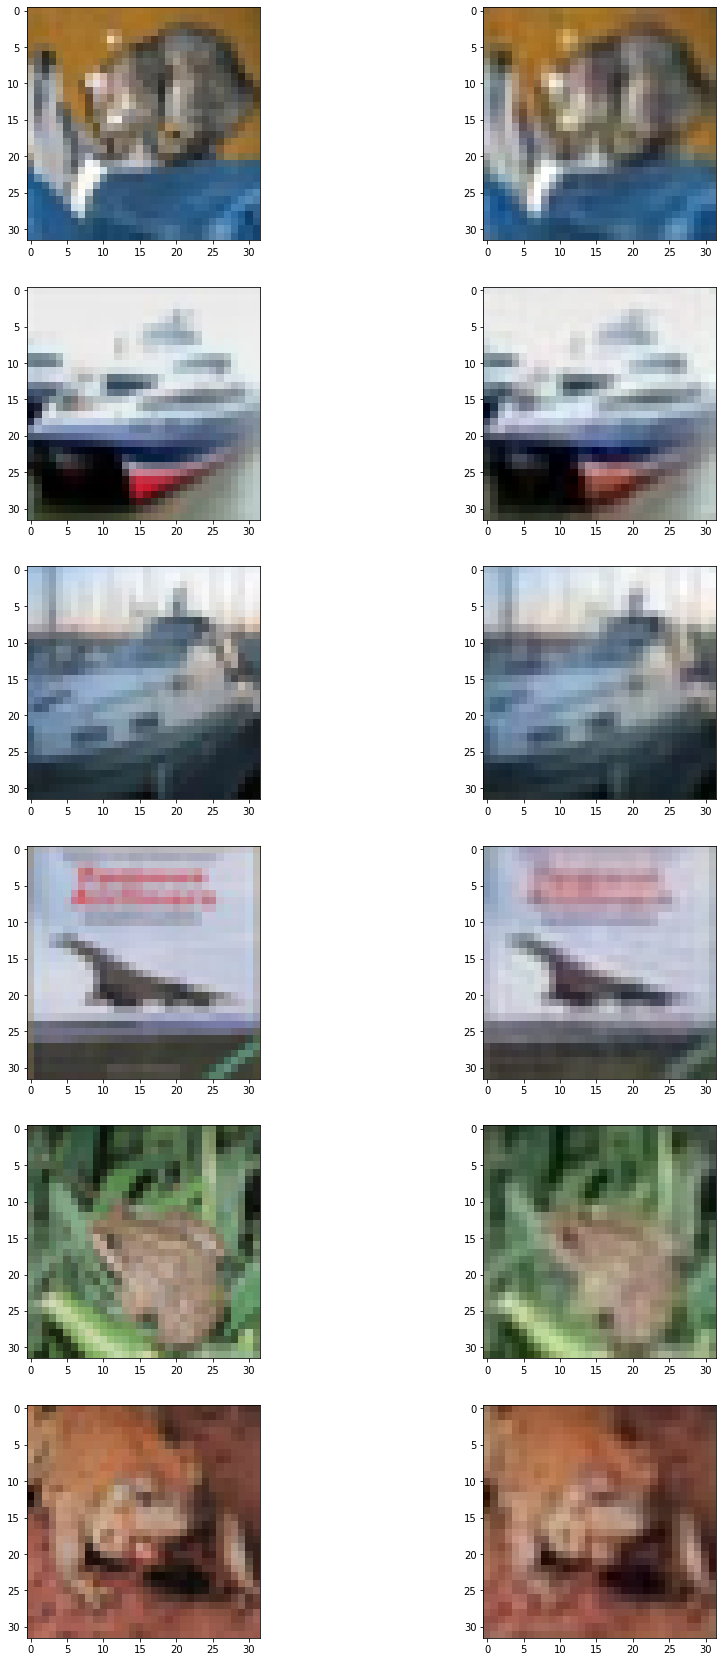

In [13]:
predictions = autoencoder.predict(x_test)
n_examples = 6
fig, axes = plt.subplots(nrows=n_examples,ncols=2, figsize=(15,30))
for i in range(n_examples):
    axes[i][0].imshow(x_test[i])
    axes[i][1].imshow(predictions[i])
plt.show()

Number of trainable parameters for a convolutional layer:
+ #filters \* filter_size_x \* filter_size_y \* #input_channels \+ bias (each filter has a bias)<br> 
=> hidden_encoder has 8 \* 5 \* 5 \* 3 \+ 8 = 608 <br>
=> output_encoder has 8 \* 5 \* 5 \* 8 \+ 8 = 1608

Number of trainable parameters for a transposed convolutional layer:
+ #filters \* filter_size_x \* filter_size_y \* #input_channels \+ bias (each filter has a bias)<br>
=> hidden_decoder 8 \* 5 \* 5 \* 8 \+ 8 = 1608 <br>
=> output_decoder 3 \* 5 \* 5 \* 8 \+ 3 = 603 <br>

Therefore we have a total of trainable parameters of 608 \+ 1608 \+ 1608 \+ 603 = 4427, which corresponds to the ouput of the keras.summary() function above.

Encode the data set

In [14]:
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

print('x_train_encoded shape:', x_train_encoded.shape)
print('x_test_encoded shape:', x_test_encoded.shape)


x_train_encoded shape: (50000, 8, 8, 8)
x_test_encoded shape: (10000, 8, 8, 8)


Implement and train a classifier on the encoded data.

In [15]:
input_classifier = Input(shape=(8, 8, 8))
conv2d_1 = Conv2D(8, (3, 3), strides=1, padding='same', activation='elu')(input_classifier)
conv2d_2 = Conv2D(8, (3, 3), strides=1, padding='same', activation='elu')(conv2d_1)
flatten = Flatten()(conv2d_2)
output_classifier = Dense(10, activation='softmax')(flatten)
classifier = Model(inputs=input_classifier, outputs=output_classifier, name='classifier')
classifier.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

indices = np.arange(int(x_train.shape[0]*0.02))
class_x_train = x_train_encoded[indices]
class_y_train = y_train[indices]

print('class_x_train shape:', class_x_train.shape)
print('class_y_train shape:', class_y_train.shape)

classifier.fit(x=class_x_train, y=class_y_train, validation_split=0.2, epochs=8)
classifier.evaluate(x_test_encoded, y_test)


Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 8, 8, 8)]         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 6,298
Trainable params: 6,298
Non-trainable params: 0
_________________________________________________________________
class_x_train shape: (1000, 8, 8, 8)
class_y_train shape: (1000, 10)
Epoch 1/8
25/25 [==============================] - 

[1.9501146078109741, 0.31349998712539673]

Add noise to the images and use the autoencoder as a denoiser to predict the original images from the noisy images (sigma = 0.06, reconstruction error <= 0.0025)

In [18]:
x_train_pure = x_train
x_test_pure = x_test
train_noise = np.random.normal(0, 0.06, x_train_pure.shape)
test_noise = np.random.normal(0, 0.06, x_test_pure.shape)
x_train_noised = x_train_pure + train_noise
x_test_noised = x_test_pure + test_noise

tf.keras.backend.clear_session()

autoencoder.compile(optimizer=Adam(learning_rate=0.002, decay=0.00001), loss=MeanSquaredError())

autoencoder.fit(x_train_noised, x_train_pure, epochs=10, validation_split=0.1)
autoencoder.evaluate(x_test_noised, x_test_pure)
denoised_predictions = autoencoder.predict(x_test_noised)


Epoch 1/10
1407/1407 [==============================] - 35s 24ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 2/10
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/10
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/10
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/10
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/10
1407/1407 [==============================] - 35s 25ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/10
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/10
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/10
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/10
313/313 [==============================] - 3s 10ms/s

Visualise the noise-less images, the noisy images and the reconstructed images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


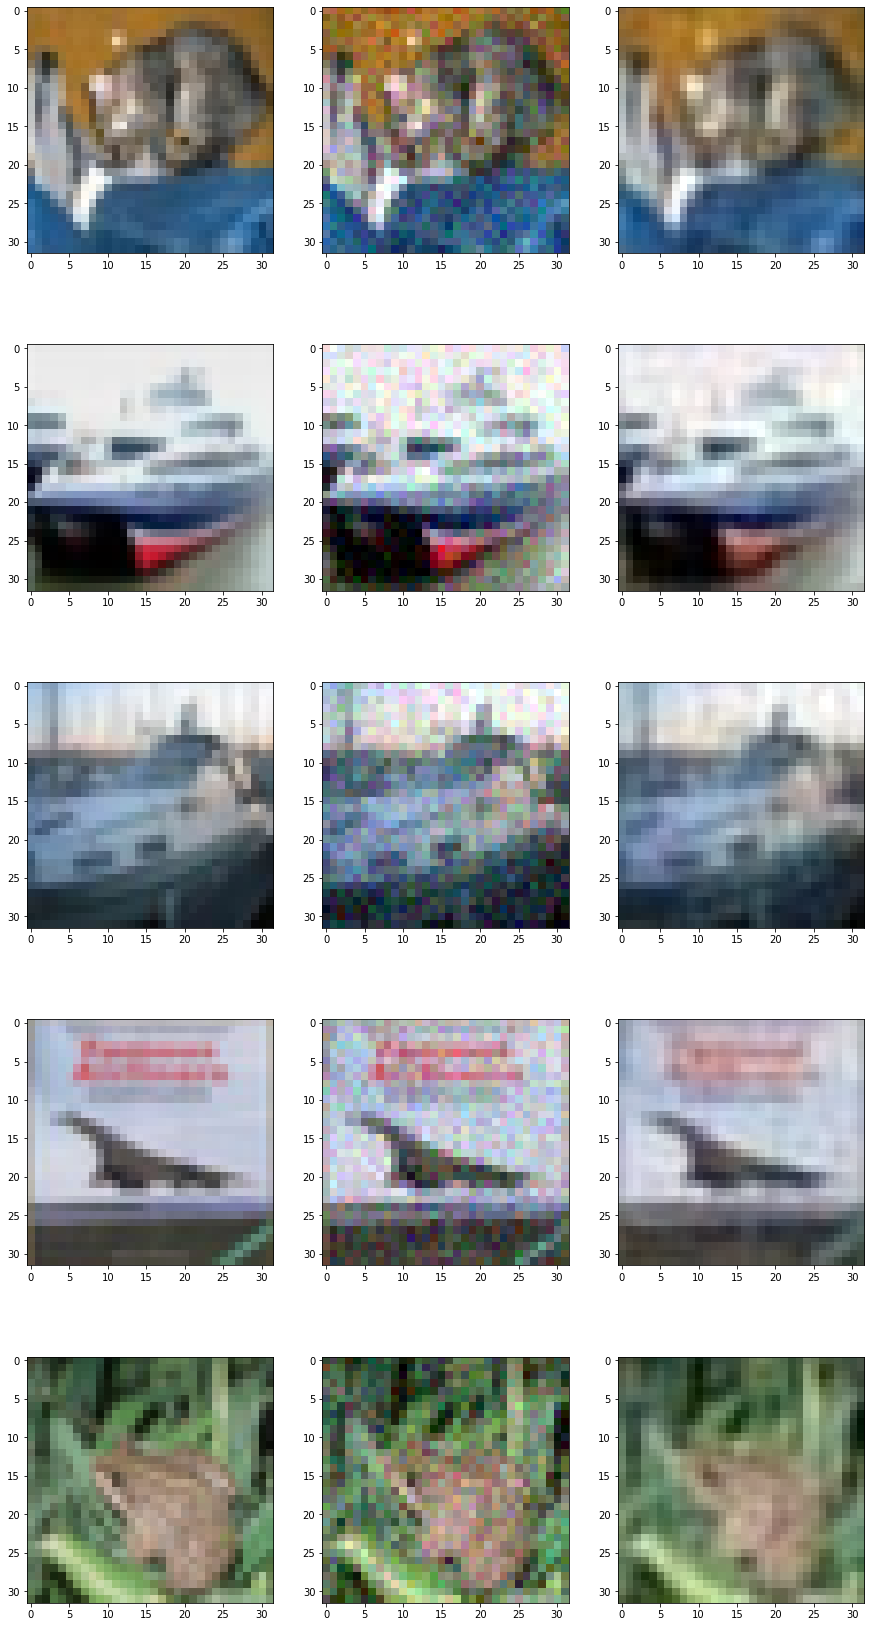

In [19]:
n_examples = 5
fig, axes = plt.subplots(nrows=n_examples,ncols=3, figsize=(15,30))
for i in range(n_examples):
    axes[i][0].imshow(x_test[i])
    axes[i][1].imshow(x_test_noised[i])
    axes[i][2].imshow(denoised_predictions[i])
plt.show()